# Figure 5: Grouped dCRE/dSO, dSST/dSO, dSWCRE/dSO

In [22]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Tuple
from scipy.stats import linregress, ttest_ind

# Plotting Utils

In [25]:
def _global_plot(
    ax, 
    data, 
    lon, 
    lat, 
    cmap, 
    pvalues=None, 
    right_title="", 
    left_title="", 
    levels=np.arange(-4, 4.1, .1), 
    cbar_label: str = "",
    contours=None,
    pr=None,
    wind=None,
):
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend="both",
        levels=levels,
    )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
    
    if wind is not None:
        # Scale reg maps 25 
        # q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], scale=150, headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        # Scale for Pr wind maps
        q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        ax.quiverkey(q, .9, -.15, .25, str(.25) + r' $\frac{m}{s}/\sigma$', labelpos='E', transform=ccrs.PlateCarree(), coordinates='axes')
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Southern ITCZ 
    bound_region(ax, lons=(-130, -80), lats=(-20, 0), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -45, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # add cbar label to top of colorbar
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    cbar.ax.set_title(cbar_label, fontsize=10)

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def fix_coords_no_swap(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    return data

def fix_coords_no_time(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(0, 360))
    return data

def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

# Load Data

In [ ]:
# SWCRE
cmip6_monthly_swcre = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcre_cmip6_monthly_1850-2000.nc"))
cmip5_monthly_swcre = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcre_cmip5_monthly_1850-2000.nc"))
cmip_monthly_swcre = xr.concat([cmip6_monthly_swcre, cmip5_monthly_swcre], dim="model")

cmip6_monthly_lwcre = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/lwcre_cmip6_monthly_1850-2000.nc"))
cmip5_monthly_lwcre = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/lwcre_cmip5_monthly_1850-2000.nc"))
cmip_monthly_lwcre = xr.concat([cmip6_monthly_lwcre, cmip5_monthly_lwcre], dim="model")

In [ ]:
# Maps of dX/dSO for 5-year anomalies CMIP Models
reg_so_dataset = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/reg_so_dataset.nc")
# CMIP PRECIPITATION
pr_cmip6 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/pr_mon_1850-2100_CMIP6_piControl.nc")
pr_cmip5 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/pr_mon_1850-2100_CMIP5_piControl.nc")
pr_cmip =  xr.concat([pr_cmip6, pr_cmip5], dim="model")
pr_cmip = fix_coords_no_swap(pr_cmip)
pr_south_east = pr_cmip.sel(lon=slice(230, 290), lat=slice(-20, 0)).spatial.average("pr")["pr"]
pr_south_east_clim = pr_south_east.mean("time")*86400

# Get half models with more precip than median
pr_south_east_clim, reg_so_dataset = get_shared_models(pr_south_east_clim, reg_so_dataset)
cmip_top = pr_south_east_clim[pr_south_east_clim >= pr_south_east_clim.median()].model
cmip_bottom = pr_south_east_clim[pr_south_east_clim < pr_south_east_clim.median()].model

def calc_grouped_diff_p_values(cmip_ds, variable, cmip_top, cmip_bottom):
    cmip_ds = cmip_ds[variable]
    cmip_ds_top = cmip_ds.sel(model=cmip_top)
    cmip_ds_bottom = cmip_ds.sel(model=cmip_bottom)

    # Get the lat/lon dimensions
    latitudes = cmip_ds.coords['lat']
    longitudes = cmip_ds.coords['lon']

    # Initialize an array to store the p-values
    p_values = np.full((len(latitudes), len(longitudes)), np.nan)  # Fill with NaN initially

    # Iterate through each latitude and longitude
    for i, lat in enumerate(latitudes):
        for j, lon in enumerate(longitudes):
            # Extract data for the current grid point
            data1 = cmip_ds_top.sel(lat=lat, lon=lon).values
            data2 = cmip_ds_bottom.sel(lat=lat, lon=lon).values
            
            # Drop NaNs from both arrays
            data1_clean = data1[~np.isnan(data1)]
            data2_clean = data2[~np.isnan(data2)]
            
            # Check if there is still valid data in both arrays after removing NaNs
            if len(data1_clean) > 0 and len(data2_clean) > 0: #and (len(data1_clean) == len(data2_clean)):
                # Perform Welch's t-test
                _, p_value_t = ttest_ind(data1_clean, data2_clean, equal_var=False)
                # Save the p-value to the array
                p_values[i, j] = p_value_t

    return p_values, cmip_ds_top.mean("model") - cmip_ds_bottom.mean("model")


# GROUP THE REGRESSION COEFFICIENTS BY MAGNITUDE OF CLIM PRECIPITATION
reg_so_dataset = fix_coords_no_time(reg_so_dataset)
p_values_cre, reg_cre_cmip_diff = calc_grouped_diff_p_values(reg_so_dataset, "reg_so_cre", cmip_top, cmip_bottom)
p_values_swcre, reg_swcre_cmip_diff = calc_grouped_diff_p_values(reg_so_dataset, "reg_so_swcre", cmip_top, cmip_bottom)
p_values_sst, reg_sst_cmip_diff = calc_grouped_diff_p_values(reg_so_dataset, "reg_so_sst", cmip_top, cmip_bottom)
p_values_uas, reg_uas_cmip_diff = calc_grouped_diff_p_values(reg_so_dataset, "reg_so_uas", cmip_top, cmip_bottom)
p_values_vas, reg_vas_cmip_diff = calc_grouped_diff_p_values(reg_so_dataset, "reg_so_vas", cmip_top, cmip_bottom)

# Figure 5

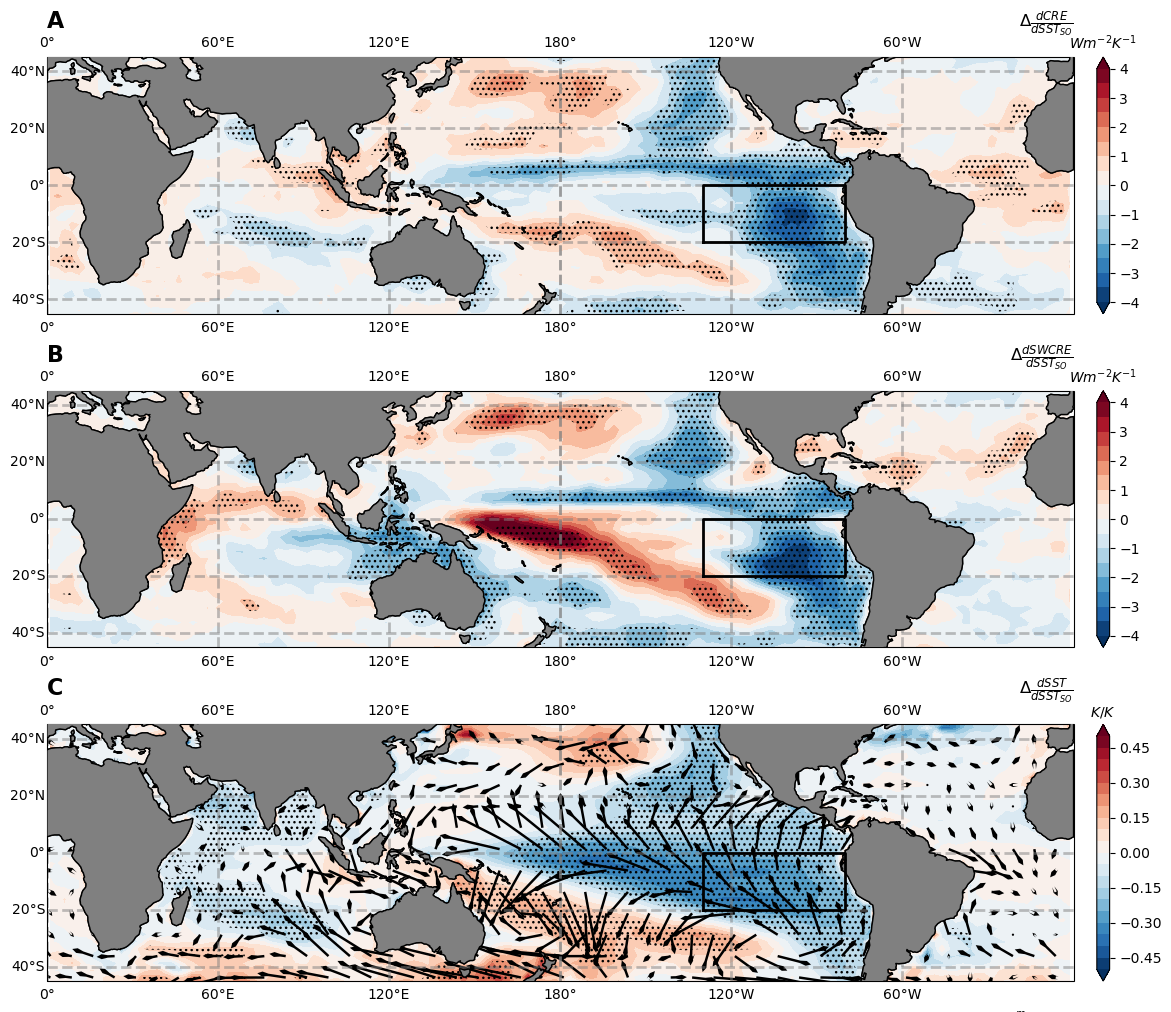

In [31]:
############### SETUP ############
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 1, hspace=0.30) 
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)
ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

############### GROUPED dCRE/dSO ############
img = _global_plot(
    ax1,
    data=reg_cre_cmip_diff,
    lat=reg_sst_cmip_diff.lat,
    lon=reg_sst_cmip_diff.lon,
    cmap="RdBu_r",
    cbar_label=r"$Wm^{-2}K^{-1}$",
    levels=np.arange(-4, 4.5, .5),
    pvalues=p_values_cre,
)
ax1.set_title(r"$\Delta \frac{dCRE}{dSST_{SO}}$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title("A", loc="left", fontweight="bold", fontsize=title_fontsize)

############### GROUPED dSWCRE/dSO ############
img = _global_plot(
    ax2,
    data=reg_swcre_cmip_diff,
    lat=reg_sst_cmip_diff.lat,
    lon=reg_sst_cmip_diff.lon,
    cmap="RdBu_r",
    cbar_label=r"$Wm^{-2}K^{-1}$",
    levels=np.arange(-4, 4.5, .5),
    pvalues=p_values_swcre,
)
ax2.set_title(r"$\Delta \frac{dSWCRE}{dSST_{SO}}$", loc="right", fontsize=title_fontsize*.75)
ax2.set_title("B", loc="left", fontweight="bold", fontsize=title_fontsize)

############### GROUPED dSST/dSO dWind/dSO ############
img = _global_plot(
    ax3,
    data=reg_sst_cmip_diff,
    lat=reg_sst_cmip_diff.lat,
    lon=reg_sst_cmip_diff.lon,
    cmap="RdBu_r",
    cbar_label=r"$K/K$",
    levels=np.arange(-.5, .55, .05),
    wind={"uas": reg_uas_cmip_diff.values, "vas": reg_vas_cmip_diff.values},
    pvalues=p_values_sst,
)
ax3.set_title(r"$\Delta \frac{dSST}{dSST_{SO}}$", loc="right", fontsize=title_fontsize*.75)
ax3.set_title("C", loc="left", fontweight="bold", fontsize=title_fontsize)

#########################################################################
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_5.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_5.pdf", dpi=300, bbox_inches="tight")